# Marketing Campaign Response Prediction & Dashboard

## Project Overview
This project builds an end-to-end machine learning solution to predict customer response to marketing campaigns and translate model outputs into actionable business insights using interactive Tableau dashboards. The objective is to help marketing teams improve campaign effectiveness by identifying high-probability customers.

## Problem Statement
Marketing campaigns are often expensive and inefficient when targeted broadly. This project aims to:
- Predict which customers are likely to respond to a campaign
- Compare multiple machine learning models based on performance
- Use probability-based predictions for smarter customer targeting

## Dataset
The dataset includes customer demographic, financial, and campaign interaction features such as:
- Customer attributes: age, job, education, balance
- Campaign details: contact method, duration, previous outcomes
- Response indicator (used for model training)

## Approach
1. Data cleaning and feature engineering  
2. Model training using Logistic Regression, Random Forest, and XGBoost  
3. Model evaluation using ROC-AUC and classification metrics  
4. Probability-based prediction and high-probability customer identification  
5. Export of clean datasets for Tableau visualization  

## Outcomes
- Identified the most effective model for predicting campaign response
- Generated customer-level response probabilities
- Built interactive dashboards to support data-driven marketing decisions

## Tools & Technologies
- Python (Pandas, NumPy, Scikit-learn, XGBoost)
- Tableau for visualization
- Git & GitHub for version control


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv('bank-full.csv',sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
print(df.shape)

(45211, 17)


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None


In [6]:
print(df.describe())

                age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       -1.000000      0.

In [7]:
print(df.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


Check target distribution

In [8]:
df['y'].value_counts(normalize=True)

,proportion
y,
no,0.883015
yes,0.116985


Customer Age Distribution

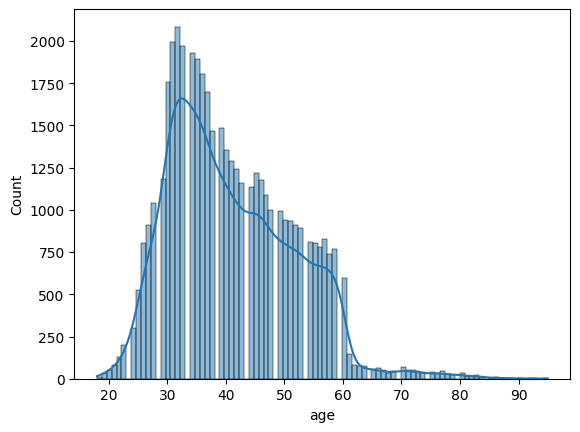

In [9]:
sns.histplot(df['age'],kde=True)
plt.show()

Job Distribution

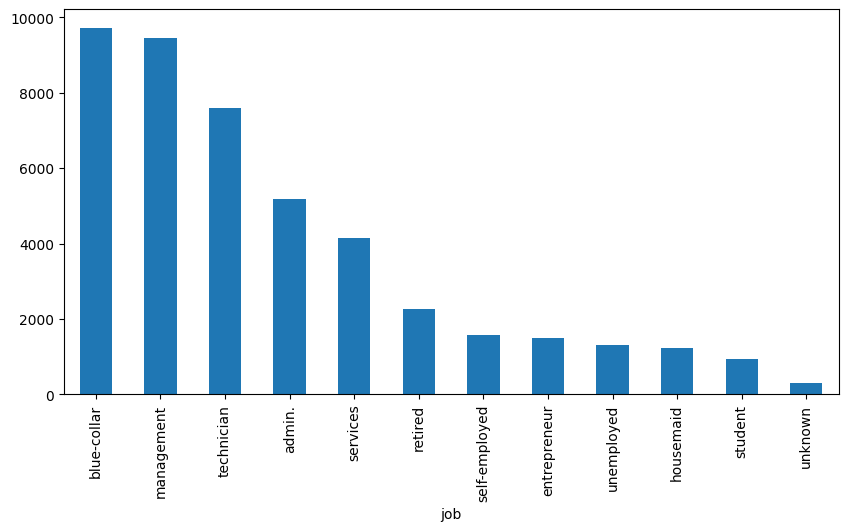

In [10]:
df['job'].value_counts().plot(kind='bar',figsize=(10,5))
plt.show()

Education Level

In [11]:
df['education'].value_counts()

,count
education,
secondary,23202
tertiary,13301
primary,6851
unknown,1857


Effect of Call Duration

<Axes: xlabel='y', ylabel='duration'>

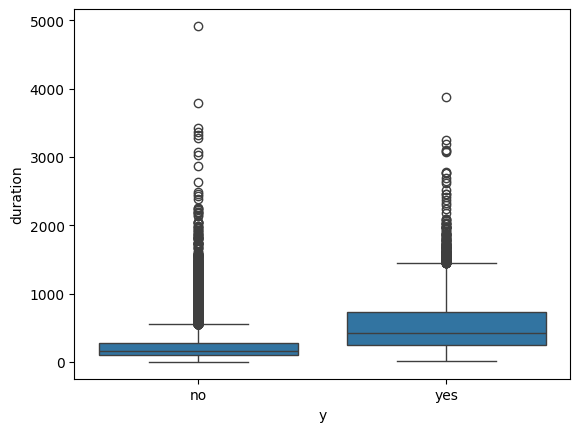

In [12]:
sns.boxplot(x='y', y='duration', data=df)

Number of contacts during the campaign

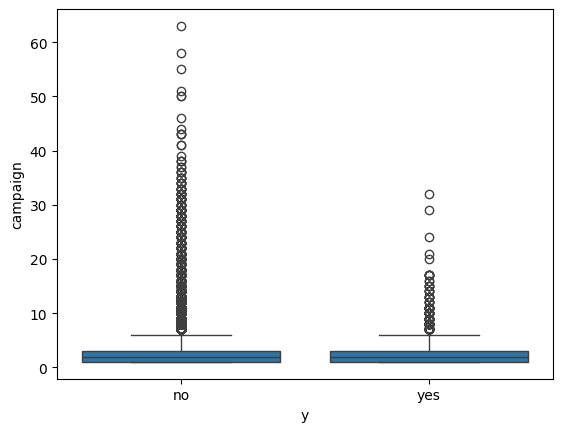

In [13]:
sns.boxplot(x='y', y='campaign', data=df)
plt.show()

Month Analysis

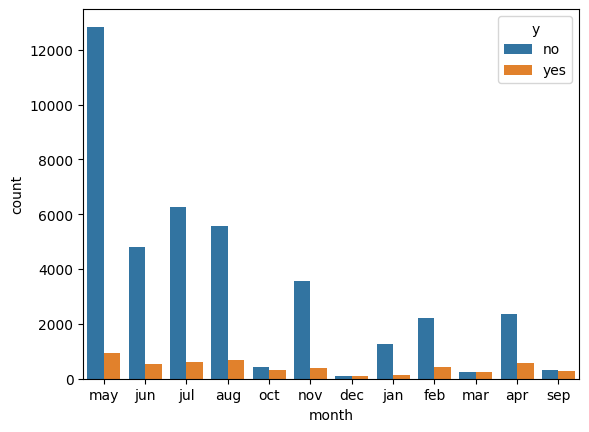

In [14]:
sns.countplot(x='month',hue='y',data=df)
plt.show()

Previous Campaign Outcome

In [15]:
df.groupby('poutcome')['y'].value_counts(normalize=True)

poutcome  y  
failure   no     0.873903
          yes    0.126097
other     no     0.833152
          yes    0.166848
success   yes    0.647253
          no     0.352747
unknown   no     0.908385
          yes    0.091615
Name: proportion, dtype: float64

Feature Engineering

Identify categorical vs numerical columns

In [16]:
cat_cols=df.select_dtypes(include=['object']).columns
num_cols=df.select_dtypes(include=['int64','float64']).columns

cat_cols, num_cols

(Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
        'month', 'poutcome', 'y'],
       dtype='object'),
 Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object'))

Encode binary yes/no columns

In [17]:
binary_cols=['default','housing','loan','y']

from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

for col in binary_cols:
  df[col]=le.fit_transform(df[col])


Non-binary categorical columns

Use One-Hot Encoding

In [18]:
df=pd.get_dummies(df,columns=['job','marital','education','contact','month','poutcome'],drop_first=True)


Scale numerical features

Since logistic regression and SVM benefit from scaling

In [19]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

df[num_cols]=scaler.fit_transform(df[num_cols])

In [20]:
df.shape

(45211, 43)

Train–Test Split

In [21]:
from sklearn.model_selection import train_test_split

X=df.drop('y',axis=1)
y=df['y']

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()


((36168, 42),
 (9043, 42),
 y
 0    31937
 1     4231
 Name: count, dtype: int64,
 y
 0    7985
 1    1058
 Name: count, dtype: int64)

Class Weights

Logistic Regression with class weights

In [22]:
from sklearn.linear_model import LogisticRegression

log_reg=LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

Random Forest with class weights

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(class_weight='balanced', random_state=42)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

XGBoost class weights equivalent

In [24]:
pos= y_train.value_counts()[1]
neg=y_train.value_counts()[0]

scale=neg/pos
scale

np.float64(7.548333727251241)

In [25]:
import xgboost as xgb

xgb_model=xgb.XGBClassifier(scale_pos_weight=scale,random_state=42, eval_metric='logloss')

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Model Evaluation

Predictions and Metrics Import

In [26]:
y_pred_lr=log_reg.predict(X_test)
y_pred_rf=rf.predict(X_test)
y_pred_xgb=xgb_model.predict(X_test)

Logistic Regression Metrics

In [27]:
from sklearn.metrics import classification_report , confusion_matrix, roc_auc_score

print('Logistic Regression')
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print('ROC-AUC Score: ', roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1]))

Logistic Regression
[[6788 1197]
 [ 197  861]]
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      7985
           1       0.42      0.81      0.55      1058

    accuracy                           0.85      9043
   macro avg       0.70      0.83      0.73      9043
weighted avg       0.91      0.85      0.87      9043

ROC-AUC Score:  0.9079114549610386


Random Forest Metrics

In [28]:
print('Random Forest')
print(confusion_matrix(y_test,y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print('ROC-AUC Score:',roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

Random Forest
[[7818  167]
 [ 705  353]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.68      0.33      0.45      1058

    accuracy                           0.90      9043
   macro avg       0.80      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043

ROC-AUC Score: 0.9279361231420444


XGBoost Metrics

In [29]:
print('XGBoost')
print(confusion_matrix(y_test,y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print('ROC-AUC-Score:',roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]))

XGBoost
[[7053  932]
 [ 209  849]]
              precision    recall  f1-score   support

           0       0.97      0.88      0.93      7985
           1       0.48      0.80      0.60      1058

    accuracy                           0.87      9043
   macro avg       0.72      0.84      0.76      9043
weighted avg       0.91      0.87      0.89      9043

ROC-AUC-Score: 0.9263336975164919


Model Comparison

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
def evaluate_model(name, model, X_test, y_test):
  y_pred=model.predict(X_test)
  y_prob=model.predict_proba(X_test)[:,1]

  return{
      'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
  }

results=[]

results.append(evaluate_model('Logistic Regression',log_reg, X_test, y_test))
results.append(evaluate_model('Random Forest',rf, X_test, y_test))
results.append(evaluate_model('XGBoost',xgb_model, X_test, y_test))

df_results = pd.DataFrame(results)
print(df_results)

                 Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0  Logistic Regression  0.845848   0.418367  0.813800  0.552632  0.907911
1        Random Forest  0.903572   0.678846  0.333648  0.447402  0.927936
2              XGBoost  0.873825   0.476698  0.802457  0.598098  0.926334


Confusion Matrix Heatmaps

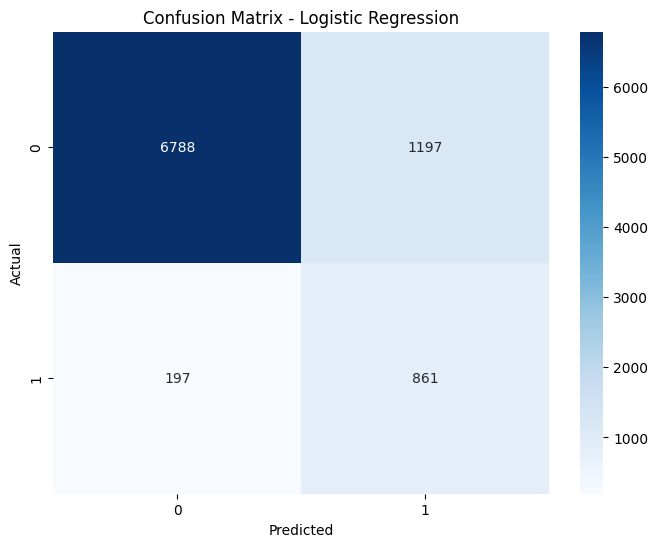

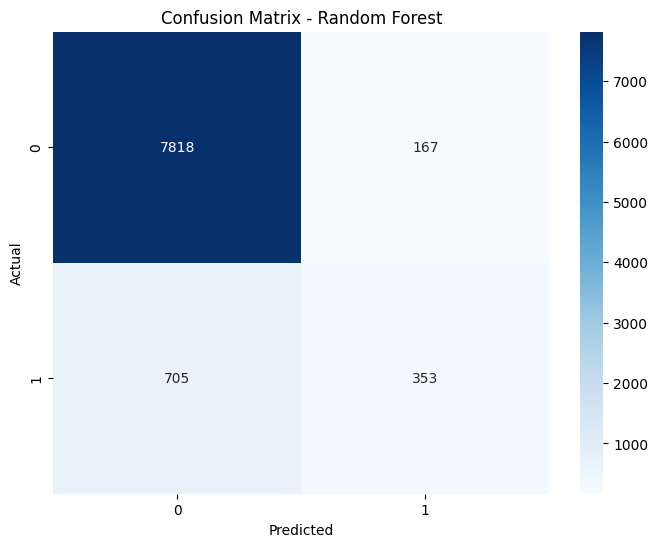

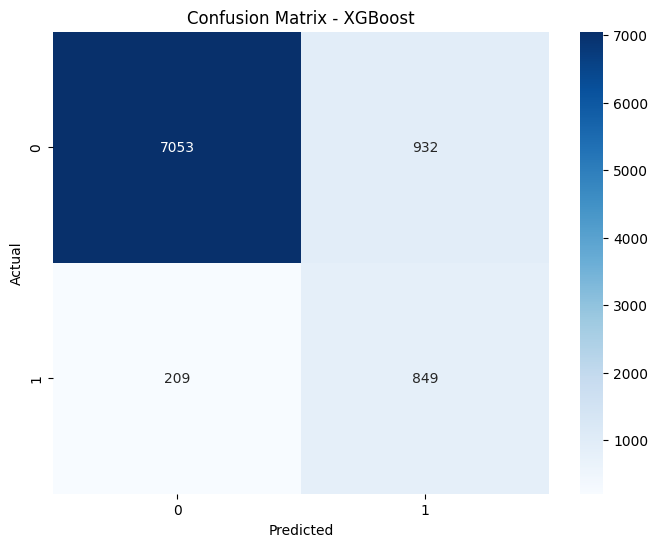

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_cm(model, X_test, y_test, title):
  y_pred=model.predict(X_test)
  cm= confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(8,6))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(f'Confusion Matrix - {title}')
  plt.show()

plot_cm(log_reg, X_test, y_test,'Logistic Regression')
plot_cm(rf, X_test, y_test,'Random Forest')
plot_cm(xgb_model, X_test, y_test,'XGBoost')

Feature Importance

Random Forest Feature Importance

In [32]:
importances= rf.feature_importances_
features=X_train.columns

rf_importance_df=pd.DataFrame({'Features':features, 'Importance':importances})
rf_importance_df.sort_values(by='Importance',ascending=False).head(20)



,Features,Importance
6,duration,0.351077
2,balance,0.081263
0,age,0.076905
5,day,0.070809
27,contact_unknown,0.038763
40,poutcome_success,0.037493
8,pdays,0.037463
7,campaign,0.035587
3,housing,0.026828
9,previous,0.018338


XGBoost Feature Importance

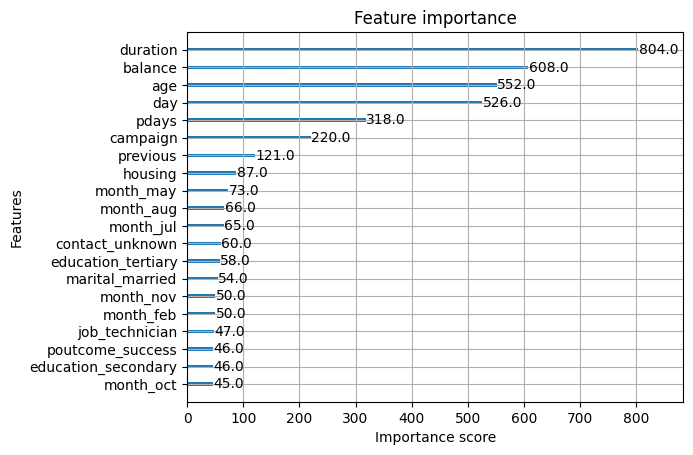

In [33]:
xgb.plot_importance(xgb_model, max_num_features=20)
plt.show()

**Business Insights**

1. **Low Campaign Response Rate**
   - Only X% customers subscribed.
   - Marketing needs to focus on targeted campaigns.

2. **High-Response Customer Segments**
   - Age groups 30–45 have higher subscription rates.
   - Specific job roles like students, retired, and management respond more.

3. **Effectiveness of Contact Method**
   - Cellular contact leads to better conversions compared to telephone.

4. **Influence of Call Duration**
   - Longer duration calls strongly increase chances of subscription.
   - Improving call quality can boost conversions.

5. **Past Campaign Effect**
   - Customers who were successful in previous campaigns show higher probability to subscribe again.

6. **Model Value**
   - The predictive model helps identify high-probability customers, reducing unnecessary marketing costs.



**Data Exports for Tableau Dashboards**

For comprehensive analysis and dashboard creation in Tableau, three key CSV files have been exported:

tableau_marketing_clean_data.csv: This file contains the preprocessed raw dataset, cleaned column names, and a new previously_contacted feature, with the target variable y removed. It's ideal for descriptive analysis of customer demographics and campaign characteristics.

tableau_predictions_clean.csv: This file includes the X_test data (test set features), the actual y_test responses, and the predicted probabilities and class predictions from the Logistic Regression, Random Forest, and XGBoost models. This is crucial for evaluating model performance and understanding predictions at an individual customer level in Tableau.

model_comparison.csv: This file provides a summary of key performance metrics (Accuracy, Precision, Recall, F1-Score, ROC-AUC) for each of the trained models. It enables a direct comparison of model effectiveness in a dashboard.

These exports facilitate a seamless integration with Tableau for in-depth visualization and business intelligence reporting.

In [34]:
import pandas as pd

df_raw = pd.read_csv("bank-full.csv", sep=";")

#Create Tableau base copy
tableau_base = df_raw.copy()

#Clean column names (Tableau-friendly)
tableau_base.columns = (
    tableau_base.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)
tableau_base["previously_contacted"] = tableau_base["pdays"].apply(
    lambda x: "No" if x == -1 else "Yes"
)

#Drop target column for Tableau business dashboard
tableau_base = tableau_base.drop(columns=["y"], errors="ignore")

#Export Tableau base CSV
tableau_base.to_csv(
    "tableau_marketing_clean_data.csv",
    index=False,
    encoding="utf-8"
)

#VALIDATION
print("✅ CORRECT Tableau base data created (delimiter fixed)")
print("\nPreview:")
print(tableau_base.head())

print("\nColumn types:")
print(tableau_base.dtypes)


✅ CORRECT Tableau base data created (delimiter fixed)

Preview:
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome  \
0  unknown    5   may       261         1     -1         0  unknown   
1  unknown    5   may       151         1     -1         0  unknown   
2  unknown    5   may        76         1     -1         0  unknown   
3  unknown    5   may        92         1     -1         0  unknown   
4  unknown    5   may       198         1     -1         0  unknown   

  previously_contacted  
0                   No  
1             

In [36]:
import pandas as pd

# Start from RAW Tableau base data
tableau_predictions = tableau_base.loc[X_test.index].copy()

# Add actual response
tableau_predictions["Actual_Response"] = y_test.values

# Calculate probabilities for each model
pred_lr = log_reg.predict_proba(X_test)[:, 1]
pred_rf = rf.predict_proba(X_test)[:, 1]
pred_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Add probabilities
tableau_predictions["LR_Probability"] = pred_lr
tableau_predictions["RF_Probability"] = pred_rf
tableau_predictions["XGB_Probability"] = pred_xgb

# Add predictions
tableau_predictions["LR_Prediction"] = (pred_lr >= 0.5).astype(int)
tableau_predictions["RF_Prediction"] = (pred_rf >= 0.5).astype(int)
tableau_predictions["XGB_Prediction"] = (pred_xgb >= 0.5).astype(int)

# Export
tableau_predictions.to_csv(
    "tableau_predictions_clean.csv",
    index=False,
    encoding="utf-8"
)

# Preview
tableau_predictions.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,previous,poutcome,previously_contacted,Actual_Response,LR_Probability,RF_Probability,XGB_Probability,LR_Prediction,RF_Prediction,XGB_Prediction
1392,40,blue-collar,married,primary,no,640,yes,yes,unknown,8,...,0,unknown,No,0,0.031508,0.00,0.000714,0,0,0
7518,44,technician,married,secondary,no,378,yes,no,unknown,30,...,0,unknown,No,0,0.039788,0.00,0.002871,0,0,0
12007,31,services,married,secondary,no,356,yes,no,unknown,20,...,0,unknown,No,0,0.079015,0.01,0.000968,0,0,0
5536,36,blue-collar,married,primary,no,655,yes,no,unknown,23,...,0,unknown,No,0,0.016296,0.01,0.002300,0,0,0
29816,34,services,single,secondary,no,1921,yes,no,cellular,4,...,0,unknown,No,0,0.184963,0.04,0.003300,0,0,0


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

model_comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, log_reg.predict(X_test)),
        accuracy_score(y_test, rf.predict(X_test)),
        accuracy_score(y_test, xgb_model.predict(X_test))
    ],
    "Precision": [
        precision_score(y_test, log_reg.predict(X_test)),
        precision_score(y_test, rf.predict(X_test)),
        precision_score(y_test, xgb_model.predict(X_test))
    ],
    "Recall": [
        recall_score(y_test, log_reg.predict(X_test)),
        recall_score(y_test, rf.predict(X_test)),
        recall_score(y_test, xgb_model.predict(X_test))
    ],
    "F1_Score": [
        f1_score(y_test, log_reg.predict(X_test)),
        f1_score(y_test, rf.predict(X_test)),
        f1_score(y_test, xgb_model.predict(X_test))
    ],
    "ROC_AUC": [
        roc_auc_score(y_test, pred_lr),
        roc_auc_score(y_test, pred_rf),
        roc_auc_score(y_test, pred_xgb)
    ]
})

# Export CSV
model_comparison.to_csv("model_comparison.csv", index=False)

# Preview
model_comparison.head()

,Model,Accuracy,Precision,Recall,F1_Score,ROC_AUC
0,Logistic Regression,0.845848,0.418367,0.813800,0.552632,0.907911
1,Random Forest,0.903572,0.678846,0.333648,0.447402,0.927936
2,XGBoost,0.873825,0.476698,0.802457,0.598098,0.926334
